This notebook loads in each of the three trained models and uses them to create predictions on the testing dataset. 

In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import gc
import seaborn as sns

In [13]:
from google.colab import drive
drive.mount('/content/drive')
image_size = 128
# Change path and filename as needed given the chosen qtransform parameters 
# This is because the dynamic naming of the images .h5 file will be based 
# on the chosen parameters that generated it, as a way of differentiating each file.
square_image_path = '/content/drive/MyDrive/GW/128x128_003_003_images.h5'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Load in our image dataset (features)
X = np.empty((8192, 2, image_size, image_size))
with h5py.File(square_image_path, 'r') as f:
    X[:2048, 0:2, :, :] = np.array(f['glitch'])
    X[2048:4096, 0:2, :, :] = np.array(f['background'])
    X[4096:6144, 0:2, :, :] = np.array(f['ccsn'])
    X[6144:, 0:2, :, :] = np.array(f['bbh'])

# Create our labels 
# 0 = glitch
# 1 = background
# 2 = ccsn 
# 3 = bbh
binary_labels = [i for i in range(4) for _ in range(2048)]
y = np.array(binary_labels)

print(f'Shape of features: {X.shape}')
print(f'Shape of labels: {y.shape}')

Shape of features: (8192, 2, 128, 128)
Shape of labels: (8192,)


In [15]:
# Split our dataset into train test and validation

# 80% train, 20% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# To avoid memory issues we can now delete our original array
del X, X_train, y, y_train
gc.collect()

# Check the shapes of the resulting arrays
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (1639, 2, 128, 128)
y_test shape: (1639,)


There is no need to create the validation set here, as we will only be using the testing set in this notebook anyway


The exact same model architecture is used as in each training notebook.

In [16]:
class myCNNModel(nn.Module):

    def __init__(self, hyper_params):
        super(myCNNModel, self).__init__()
        # Load in relevant hyper_params
        self.hyper_params = hyper_params
        self.current_channel_count = hyper_params['first_layer_output_channels']
        self.max_channels = hyper_params['max_channels']
        self.layers = []
        # Call our cnn builder and calculate the output size
        self._build_cnn_layers(hyper_params)
        self._calculate_output_size()
        # Transition into fully connected layer using the calculated output size
        self.flatten = nn.Flatten()
        # The output size of each fully connected layer is the input size of the following layer
        self.fc1 = nn.Linear(self.output_size, hyper_params['fc_hidden1'])
        self.fc2 = nn.Linear(hyper_params['fc_hidden1'], hyper_params['fc_hidden2'])
        self.fc3 = nn.Linear(hyper_params['fc_hidden2'], hyper_params['out_nodes'])
        self.relu = nn.ReLU()

    def _build_cnn_layers(self, hyper_params):

        current_channel_count = self.current_channel_count
        max_channels = self.max_channels
        counter = 0
        # Call the while loop to build cnn layers that double the number of channels until the specified max amount is reached  
        while current_channel_count < max_channels:
            # Check if this is the first time the loop is being run, if it is set the input channels for this layer to whatever it is in the data
            if counter == 0:
              current_channel_count = self.hyper_params['in_channels']
              next_channel_count = self.hyper_params['first_layer_output_channels']
            # If this is not the first layer, simply double the input channel count
            else:
              # Double the number of channels each time
              next_channel_count = 2 * current_channel_count


            # Apply the 2d convolution since our image is 2 dimensional 
            self.layers.append(nn.Conv2d(in_channels=current_channel_count, out_channels=next_channel_count,
                                         kernel_size=self.hyper_params['conv_kernel_size'], stride=self.hyper_params['conv_stride'], padding=self.hyper_params['conv_padding']))
            # Use batch normalization in each layer to prevent vanishing or exploding gradients 
            self.layers.append(nn.BatchNorm2d(next_channel_count))
            # Use a relu Activation function
            self.layers.append(nn.ReLU())
            # Use max pooling to extract features 
            self.layers.append(nn.MaxPool2d(kernel_size=self.hyper_params['pool_kernel_size'], stride=self.hyper_params['pool_stride']))
            current_channel_count = next_channel_count
            counter += 1
        
        self.cnn = nn.Sequential(*self.layers)

    def _calculate_output_size(self):
        '''
        Apply the formula given in class to calculate the number of output layers from the end of the convolutional portion of the network
        '''
        size = self.hyper_params['input_size']
        counter = 0

        while counter < self.hyper_params['n_conv_layers']:
            size = (size - self.hyper_params['conv_kernel_size'] + 2 * self.hyper_params['conv_padding']) // self.hyper_params['conv_stride'] + 1
            size = (size - self.hyper_params['pool_kernel_size'] + 0) // self.hyper_params['pool_stride'] + 1
            counter += 1

        self.output_size = size * size * self.max_channels

    def forward(self, x):
        # Call the cnn portion
        x = self.cnn(x)
        x = self.flatten(x)
        # Use a relu in-between each fully connected layer
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [17]:
# Set the same seed for completeness 
torch.manual_seed(69)
# Convert to tensor and move to gpu 
X_test = torch.from_numpy(X_test).float().cuda()
y_test = torch.from_numpy(y_test).long().cuda()


In [18]:
model_params = {
    'in_channels':X_train.shape[1], 
    'input_size':X_train.shape[2],
    'first_layer_output_channels':16, # The number of channels that the first conv layer should output
    'fc_hidden1':1024, # Number of fully connected nodes in layer 1 
    'fc_hidden2':256, # Number of fully connected nodes in layer 1 
    'max_channels':1024, # The max number of channels for the convolutions to create 
    'out_nodes':2, # 2 output nodes as this is a binary classifier
    # pooling and convolution params
    'conv_stride':1, 
    'pool_stride':2,
    'conv_padding':1,
    'conv_kernel_size':3,
    'pool_kernel_size':2,
    'n_conv_layers':7 # total number of conv layers
}
# Create empty model objects for each
parent_model = myCNNModel(hyper_params=model_params)
signal_model = myCNNModel(hyper_params=model_params)
glitch_bg_model = myCNNModel(hyper_params=model_params)

# Load in the pretrained model and load the state into each model object
parent_model_path = '/content/drive/MyDrive/GW/test_models/parent_model_03_003.pth'
signal_model_path = '/content/drive/MyDrive/GW/test_models/signal_model_03_003.pth'
glitch_bg_model_path = '/content/drive/MyDrive/GW/test_models/glitch_bg_model_03_003.pth'

parent_model.load_state_dict(torch.load(parent_model_path))
signal_model.load_state_dict(torch.load(signal_model_path))
glitch_bg_model.load_state_dict(torch.load(glitch_bg_model_path))

# Move each to gpu 
parent_model.cuda()
signal_model.cuda()
glitch_bg_model.cuda()

myCNNModel(
  (cnn): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1

In [19]:
# do the parent prediction 
with torch.no_grad():
    # Predict with the parent model
    y_pred_test = parent_model(X_test)
    y_pred_test_argmax = torch.argmax(y_pred_test, dim=1)
    # Separate the test set based on parent output
    # Save the indicies
    indices_glitch_bg = (y_pred_test_argmax == 0).nonzero(as_tuple=True)[0]
    indices_signal = (y_pred_test_argmax == 1).nonzero(as_tuple=True)[0]


torch.Size([1639])


In [20]:

with torch.no_grad():
    # Predict with the parent model
    y_pred_test = parent_model(X_test)
    y_pred_test_argmax = torch.argmax(y_pred_test, dim=1)
    # Separate the test set based on parent output

    indices_glitch_bg = (y_pred_test_argmax == 0).nonzero(as_tuple=True)[0]
    indices_signal = (y_pred_test_argmax == 1).nonzero(as_tuple=True)[0]



    # Select the predicted glitches and background out of the testing set and create a new test set
    X_test_glitch_bg = X_test[indices_glitch_bg]
    # make sure it is on gpu 
    X_test_glitch_bg.cuda()
    # Classify the predicted glitches/background
    y_pred_glitch_bg = glitch_bg_model(X_test_glitch_bg)
    y_pred_argmax_glitch_bg = torch.argmax(y_pred_glitch_bg, dim=1)

    # Select the predicted signals out of the testing set and create a new test set
    X_test_signal = X_test[indices_signal]
    # move to gpu
    X_test_signal.cuda()
    # Classify the predicted glitches/background
    y_pred_signal = signal_model(X_test_signal)
    y_pred_argmax_signal = torch.argmax(y_pred_signal, dim=1)

    # To match the labeleling of y_test, cast 0 to 1 and 2 to 3
    y_pred_argmax_signal[y_pred_argmax_signal == 0] = 2
    y_pred_argmax_signal[y_pred_argmax_signal == 1] = 3


    # Initialize the final prediction tensor
    y_pred_combined = torch.empty_like(y_pred_test_argmax)

    # Place the predictions back into the final tensor in the correct order
    y_pred_combined[indices_glitch_bg] = y_pred_argmax_glitch_bg
    y_pred_combined[indices_signal] = y_pred_argmax_signal

In [21]:
# Use classification report to see how the model did 
from sklearn.metrics import  classification_report

# Assuming y_test and y_pred_test_argmax are tensors on the GPU
# Move them to CPU and convert to numpy arrays
y_test_cpu = y_test.cpu().numpy()
y_pred_combined
y_pred_test_argmax_cpu = y_pred_combined.cpu().numpy()

# Define class names
class_names = ['Glitch','Background','CCSN', 'BBH']
# Generate classification report
class_report = classification_report(y_test_cpu, y_pred_test_argmax_cpu, target_names=class_names)
print('Classification Report:')
print(class_report)


Classification Report:
              precision    recall  f1-score   support

      Glitch       0.94      0.70      0.80       430
  Background       0.64      0.95      0.77       410
        CCSN       0.91      0.76      0.83       406
         BBH       1.00      0.95      0.98       393

    accuracy                           0.84      1639
   macro avg       0.87      0.84      0.84      1639
weighted avg       0.87      0.84      0.84      1639



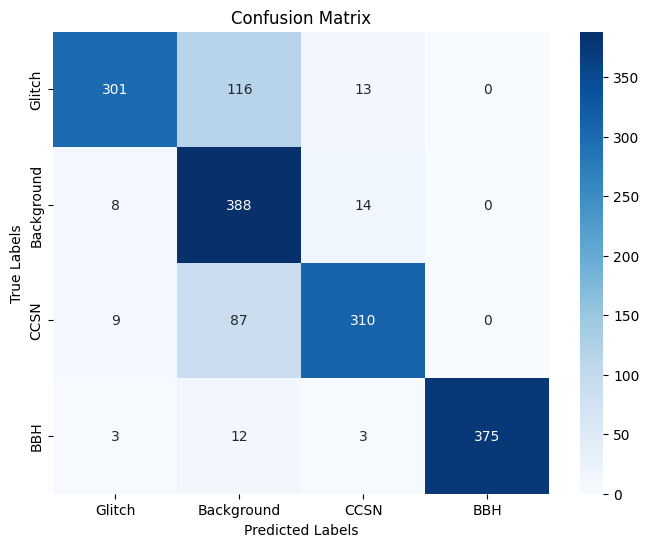

In [22]:
# Create a confusion matrix to summarize results 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_cpu, y_pred_test_argmax_cpu, normalize='true')
# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a seaborn heatmap
sns.heatmap(cm, annot=True, cmap='Blues', cbar=True,
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()